# Analysis of COVID related Studies from [ClinicalTrials.gov](www.clinicaltrials.gov)


## Read in data 

In [238]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from xml.etree import ElementTree

In [239]:
import os
list_of_files=os.listdir('./COVID_19_Studies')

df_covid = pd.DataFrame()
df = pd.DataFrame()
i=0
list_keywords=[]

In [240]:
# Read in data

for file in list_of_files:
    file_path='./COVID_19_Studies/'+file
    #print('Processing....'+file_path)
    tree = ElementTree.parse(file_path)
    root = tree.getroot()

    trial = {}

    trial['id'] = root.find('id_info').find('nct_id').text
    trial['overall_status'] = root.find('overall_status').text
    trial['study_type'] = root.find('study_type').text
    if root.find('start_date') != None:
        trial['start_date'] = root.find('start_date').text
    else:
         trial['start_date'] = ''
        
    if root.find('enrollment') != None:
        trial['enrollment'] = root.find('enrollment').text
    else:
         trial['enrollment'] = ''

    trial['condition'] = root.find('condition').text.upper().replace('CORONAVIRUS INFECTIONS','CORONAVIRUS INFECTION').replace('CORONA VIRUS INFECTION','CORONAVIRUS INFECTION').replace('SARS-COV-2','SARS-COV2').replace('SARS-COV 2','SARS-COV2').replace('COVID-19','COVID').replace('COVID19','COVID').replace('COVID 19','COVID')
    if root.find('location_countries') != None:
        trial['location_countries'] = root.find('location_countries').find('country').text.upper()
    else:
        trial['location_countries'] = ''
        
    if root.find('intervention') != None:
        trial['intervention'] = root.find('intervention').find('intervention_name').text.upper()
    else:
        trial['intervention'] = ''
        
    #trial['description'] = root.find('brief_summary')[0].text
    for entry in root.findall('keyword'):
        list_keywords.append(entry.text)

    if root.find('official_title') == None:
        trial['title'] = root.find('brief_title').text
    else:
        trial['title'] = root.find('official_title').text

    date_string = root.find('required_header').find('download_date').text
    trial['date_processed'] = date_string.replace('ClinicalTrials.gov processed this data on ', '')
    
    trial['sponsors'] = root.find('sponsors').find('lead_sponsor').find('agency').text
    
    df  = pd.DataFrame(trial,index=[i])
    i=i+1
    
    #print(trial)
    
    df_covid = pd.concat([df_covid, df])
    #print(trial)

## View head, shape, column headers, missing values, and data types

In [241]:
# View Total rows and columns 
df_covid.shape

(2439, 11)

In [242]:
# View column headers
df_covid.columns.values

array(['id', 'overall_status', 'study_type', 'start_date', 'enrollment',
       'condition', 'location_countries', 'intervention', 'title',
       'date_processed', 'sponsors'], dtype=object)

## Visualize counts of different fields

Text(0.5, 1.0, 'Recruitment Status')

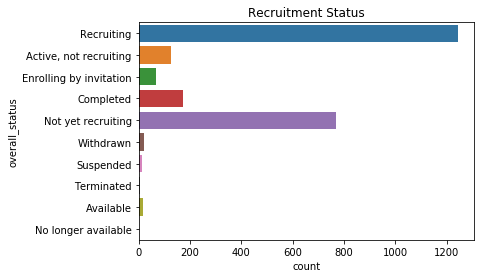

In [243]:
ax = sns.countplot(y="overall_status", data=df_covid, orient='h')
ax.set_title('Recruitment Status')

Text(0.5, 1.0, 'Study Types')

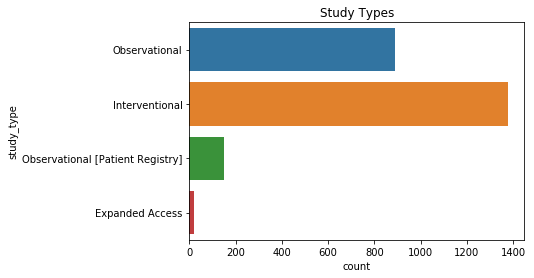

In [244]:
ax = sns.countplot(y='study_type', data=df_covid, orient='h')
ax.set_title('Study Types')

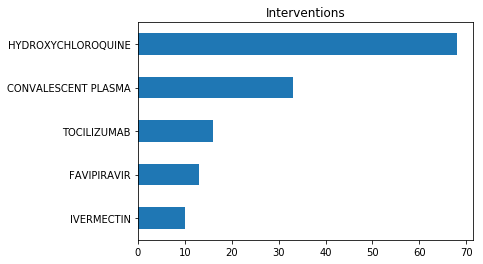

In [245]:
# get top five interventions 

interventional_studies = df_covid[df_covid['study_type']=='Interventional']

top_interventions = interventional_studies['intervention'].value_counts().sort_values(ascending=True)[-5:]

top_interventions.plot(kind='barh', title='Interventions')

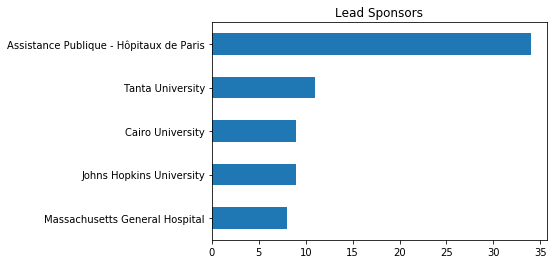

In [246]:
lead_sponsors = interventional_studies['sponsors'].value_counts().sort_values(ascending=True)[-5:]

lead_sponsors.plot(kind='barh', title='Lead Sponsors')

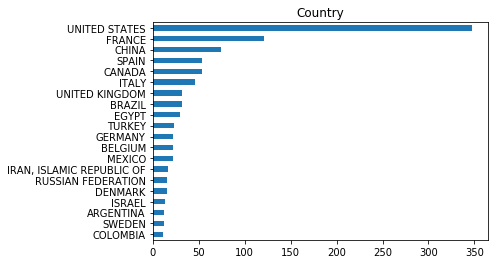

In [247]:
interventional_studies = df_covid[df_covid['study_type']=='Interventional']

countries = interventional_studies[interventional_studies['location_countries']!='']

country = countries['location_countries'].value_counts().sort_values(ascending=True)[-20:]

country.plot(kind='barh', title='Country')

# What conditions are most commonly studied?
---

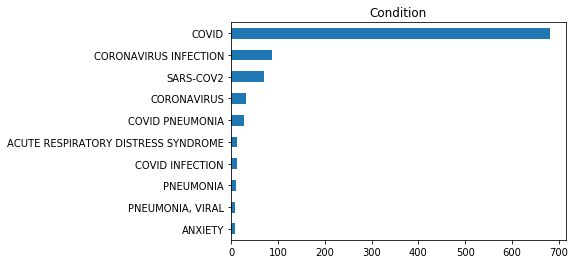

In [248]:
condition = interventional_studies['condition'].value_counts().sort_values(ascending=True)[-10:]

condition.plot(kind='barh', title='Condition')

# How large are interventional trials?
---

##### a. Clean up necessary columns
I had to convert the "Enrollment" column to numeric data type, drop NaNs, investigate possible outliers, and remove trials with recruitment status of "Withdrawn"

In [249]:
# Convert to numeric
interventional_studies['enrollment'] = interventional_studies['enrollment'].astype(int)



C:\Users\GauravGoel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [250]:
#interventional_studies.enrollment.isnull().sum()

interventional_studies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1380 entries, 1 to 2438
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1380 non-null   object
 1   overall_status      1380 non-null   object
 2   study_type          1380 non-null   object
 3   start_date          1380 non-null   object
 4   enrollment          1380 non-null   int32 
 5   condition           1380 non-null   object
 6   location_countries  1380 non-null   object
 7   intervention        1380 non-null   object
 8   title               1380 non-null   object
 9   date_processed      1380 non-null   object
 10  sponsors            1380 non-null   object
dtypes: int32(1), object(10)
memory usage: 124.0+ KB


In [251]:
interventional_studies['enrollment'].value_counts()

100    81
200    64
20     57
30     57
40     56
       ..
487     1
483     1
479     1
478     1
333     1
Name: enrollment, Length: 330, dtype: int64

In [252]:
# View enrollment stats based on each recruitment category
interventional_studies.groupby('overall_status').agg([np.mean, np.count_nonzero,])

enrollment              
                                 mean count_nonzero
overall_status                                     
Active, not recruiting    1148.806452            62
Completed                10160.775510            49
Enrolling by invitation  25959.166667            36
Not yet recruiting         619.607004           514
Recruiting                 496.143695           682
Suspended                  369.000000            14
Terminated                  80.000000             6
Withdrawn                    0.000000             0

In [253]:
# Remove the trials with recruitment status withdrawn and terminated
enrollment = interventional_studies.loc[
    (interventional_studies['overall_status'] != 'Withdrawn') & (interventional_studies['overall_status'] != 'Terminated')]

In [254]:
bins = [-1, 20, 40, 60, 100, 200, 400, 600, 1000]
group_names = ['< 20', '21-40', '41-60', '61-100', '101-200', '201-400', '401-600', '>600']
categories = pd.cut(enrollment['enrollment'], bins, labels=group_names)

In [255]:
# Add categories as column in dataframe
enrollment['Category'] = categories

C:\Users\GauravGoel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [256]:
# View value counts
enrollment_counts = enrollment['Category'].value_counts().sort_index(ascending=True)

##### b. Plot trial sizes 

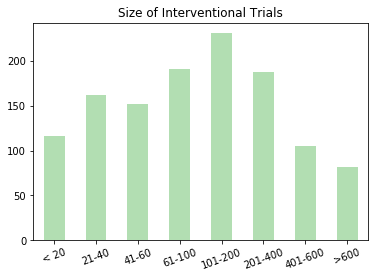

In [257]:
enrollment_counts.plot(kind='bar', title='Size of Interventional Trials', alpha=0.6, colormap='Accent', rot=20)

In [259]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [260]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

In [261]:
comment_words = '' 
stopwords = set(STOPWORDS)

In [262]:
for word in list_keywords:
    val = str(word)
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "
        

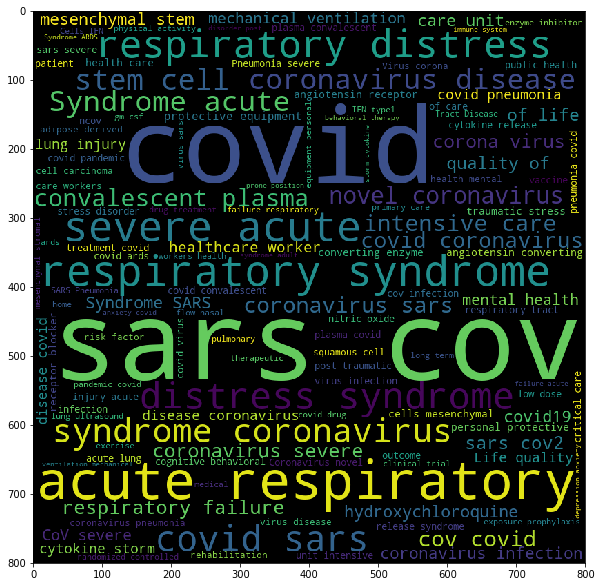

In [269]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
#plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 